# Prepare Training Set for Control Study

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
import cvxpy as cvx
s3 = boto3.resource('s3')

### Load data

In [2]:
zip_county_lookup = pd.read_csv('s3://script.forecast.inputsoutputs/zip_county_lookup_cleaned.csv')
zip_county_lookup['Zip Code'] = zip_county_lookup['Zip Code'].astype(int)

In [3]:
county_list = np.unique(zip_county_lookup['County'].values)
print('County options: ', county_list)

County options:  ['Alameda' 'Alpine' 'Amador' 'Butte' 'Calaveras' 'Colusa' 'Contra Costa'
 'Del Norte' 'El Dorado' 'Fresno' 'Glenn' 'Humboldt' 'Imperial' 'Inyo'
 'Kern' 'Kings' 'Lake' 'Lassen' 'Los Angeles' 'Madera' 'Marin' 'Mariposa'
 'Mendocino' 'Merced' 'Modoc' 'Mono' 'Monterey' 'Napa' 'Nevada' 'Orange'
 'Placer' 'Plumas' 'Riverside' 'Sacramento' 'San Benito' 'San Bernardino'
 'San Diego' 'San Francisco' 'San Joaquin' 'San Luis Obispo' 'San Mateo'
 'Santa Barbara' 'Santa Clara' 'Santa Cruz' 'Shasta' 'Sierra' 'Siskiyou'
 'Solano' 'Sonoma' 'Stanislaus' 'Sutter' 'Tehama' 'Trinity' 'Tulare'
 'Tuolumne' 'Ventura' 'Yolo' 'Yuba']


# Implement once as Example

In [4]:
county = 'Santa Clara'
# tip: only choose bay area counties

In [5]:
# Which files in this county do we have to pick from
bucket = s3.Bucket('script.chargepoint.data')
zip_options = zip_county_lookup[zip_county_lookup['County']==county]['Zip Code'].values
file_options = []

for zipcode in zip_options:
    file_name = 'clean/Reduced/By_ZipCode/evsezip'+str(zipcode)+'_sessions.csv'
    # check if have data for this zip
    have_data = False
    objs = list(bucket.objects.filter(Prefix=file_name))
    if len(objs) > 0 and objs[0].key == file_name:
        file_options.append(file_name)

In [6]:
print('Have ', len(file_options), ' zips in this county to pull from')

Have  49  zips in this county to pull from


In [7]:
zipcode_file = np.random.choice(file_options)

In [8]:
df = pd.read_csv('s3://script.chargepoint.data/'+zipcode_file)
df = df[df['POI Category']=='Workplace'].reset_index(drop=True)
df = df[df['Max Power']<=10].reset_index(drop=True) # Not fast charging

In [9]:
df_intervals = pd.read_csv('s3://script.chargepoint.data/'+zipcode_file[:37]+'_intervals.csv')

## Select Sessions and build Uncontrolled Load

In [10]:
num_sessions = 200
chosen_sessions = np.random.choice(df.index, num_sessions)

In [11]:
charge_rate = 6.6

In [17]:
power = np.zeros((96, num_sessions))
arrival_inds = np.zeros((num_sessions, ))
departure_inds = np.zeros((num_sessions, ))
for session_num in range(num_sessions):
    session = df.loc[chosen_sessions[session_num], 'Session ID']
    interval_data = df_intervals[df_intervals['Session ID']==session]
    for i in interval_data.index:
        hour = int(interval_data.loc[i, 'Interval Start Time (Local)'][11:13])
        minute = int(interval_data.loc[i, 'Interval Start Time (Local)'][14:16])
        timestep_96 = hour*4 + int(minute/15)
        power[timestep_96, session_num] = float(interval_data.loc[i, 'Average Power'])
    if power[0, session_num] == 0:
        if len(np.where(power[:, session_num] > 0)[0]) > 0:
            arrival_inds[session_num] = np.where(power[:, session_num] > 0)[0][0]
            if np.where(power[:, session_num] > 0)[0][-1] + 1 < 96:
                departure_inds[session_num] = np.where(power[:, session_num] > 0)[0][-1] + 1
            else: 
                departure_inds[session_num] = 0
    else:
        if len(np.where(power[:, session_num] == 0)[0]) > 0:
            arrival_inds[session_num] = np.max(np.where(power[:, session_num] == 0)[0]) + 1
            if arrival_inds[session_num] == 96:
                arrival_inds[session_num] = 0
            departure_inds[session_num] = np.min(np.where(power[:, session_num] == 0)[0])
energies = 0.25*charge_rate*np.sum(power, axis=0)

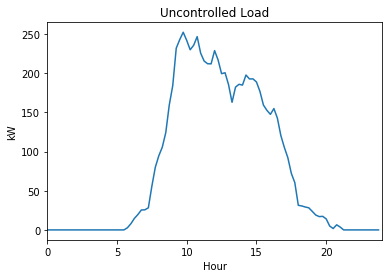

In [18]:
plt.figure()
plt.plot(0.25*np.arange(0, 96), np.sum(power, axis=1))
plt.xlabel('Hour')
plt.xlim([0, 24])
plt.ylabel('kW')
plt.title('Uncontrolled Load')
plt.show()

## Control

E-19 structure from https://www.pge.com/tariffs/assets/pdf/tariffbook/ELEC_SCHEDS_E-19.pdf, taking summer case, secondary voltage, only the variable parts of the rate schedule

Peak is noon to 6pm, partpeak is 8:30am to noon and 6pm to 9:30pm, offpeak otherwise.


In [14]:
rate_energy_peak = 0.16997
rate_energy_partpeak = 0.12236
rate_energy_offpeak = 0.09082
rate_demand_peak = 21.23
rate_demand_partpeak = 5.85
rate_demand_overall = 19.10

In [15]:
energy_prices = np.concatenate((np.repeat(rate_energy_offpeak, int(8.5*4)), np.repeat(rate_energy_partpeak, int(3.5*4)), 
                np.repeat(rate_energy_peak, int(6*4)), np.repeat(rate_energy_partpeak, int(3.5*4)), 
                np.repeat(rate_energy_offpeak, int(2.5*4))))

In [16]:
peak_inds = np.arange(int(12*4), int(18*4))
partpeak_inds = np.concatenate((np.arange(int(8.5*4), int(12*4)), np.arange(int(18*4), int(21.5*4))))
offpeak_inds = np.concatenate((np.arange(0, int(8.5*4)), np.arange(int(21.5*4), int(24*4))))

Optimization problem

In [19]:
schedule = cvx.Variable((96, num_sessions))
obj = cvx.matmul(cvx.sum(schedule, axis=1),  energy_prices.reshape((np.shape(energy_prices)[0], 1)))
obj += rate_demand_overall*cvx.max(cvx.sum(schedule, axis=1))
obj += rate_demand_peak*cvx.max(cvx.sum(schedule[peak_inds, :], axis=1))
obj += rate_demand_partpeak*cvx.max(cvx.sum(schedule[partpeak_inds, :], axis=1))

constraints = [schedule >= 0]
for i in range(num_sessions):
    constraints += [schedule[:, i] <= np.maximum(np.max(power[:, i]), charge_rate)]
    if departure_inds[i] >= arrival_inds[i]:
        if arrival_inds[i] > 0:
            constraints += [schedule[np.arange(0, int(arrival_inds[i])), i] <= 0]
        if departure_inds[i] < 96:
            constraints += [schedule[np.arange(int(departure_inds[i]), 96), i] <= 0]
    else:
        constraints += [schedule[np.arange(int(departure_inds[i]), int(arrival_inds[i])), i] <= 0]

energies = 0.25*np.sum(power, axis=0)
max_energies = np.zeros((num_sessions, ))
for i in range(num_sessions):
    if departure_inds[i] >= arrival_inds[i]:
        max_energies[i] = 0.25*charge_rate*(departure_inds[i]-arrival_inds[i])
    else:
        max_energies[i] = 0.25*charge_rate*((departure_inds[i])+(96-arrival_inds[i]))
where_violation = np.where((max_energies-energies)<0)[0]
print('Energy violation for ',len(where_violation),' of the sessions.')
energies[where_violation] = max_energies[where_violation]
constraints += [0.25*cvx.sum(schedule, axis=0)==energies]

In [20]:
prob = cvx.Problem(cvx.Minimize(obj), constraints)
result = prob.solve(cvx.MOSEK)

In [21]:
result

9365.65559893314

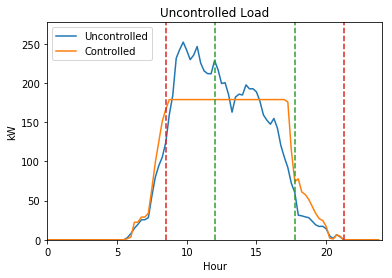

In [22]:
plt.figure()
plt.plot(0.25*np.arange(0, 96), np.sum(power, axis=1), color='C0')
plt.plot(0.25*np.arange(0, 96), np.sum(schedule.value, axis=1), color='C1')
plt.plot([0.25*np.min(peak_inds), 0.25*np.min(peak_inds)], [0, 1.1*np.max(np.sum(power, axis=1))], '--', color='C2')
plt.plot([0.25*np.max(peak_inds), 0.25*np.max(peak_inds)], [0, 1.1*np.max(np.sum(power, axis=1))], '--', color='C2')
plt.plot([0.25*np.min(partpeak_inds), 0.25*np.min(partpeak_inds)], [0, 1.1*np.max(np.sum(power, axis=1))], '--', color='C3')
plt.plot([0.25*np.max(partpeak_inds), 0.25*np.max(partpeak_inds)], [0, 1.1*np.max(np.sum(power, axis=1))], '--', color='C3')
plt.xlabel('Hour')
plt.xlim([0, 24])
plt.ylim([0, 1.1*np.max(np.sum(power, axis=1))])
plt.ylabel('kW')
plt.title('Uncontrolled Load')
plt.legend(labels=['Uncontrolled', 'Controlled'])
plt.show()

# Generate multiple profiles

In [31]:
def new_df_and_sessions(county, num_sessions):
    
    bucket = s3.Bucket('script.chargepoint.data')
    zip_options = zip_county_lookup[zip_county_lookup['County']==county]['Zip Code'].values
    file_options = []

    for zipcode in zip_options:
        file_name = 'clean/Reduced/By_ZipCode/evsezip'+str(zipcode)+'_sessions.csv'
        # check if have data for this zip
        have_data = False
        objs = list(bucket.objects.filter(Prefix=file_name))
        if len(objs) > 0 and objs[0].key == file_name:
            file_options.append(file_name)

    ct = 0
    len_df = 0
    while ((len_df==0) & (ct < len(file_options))):
        zipcode_file = np.random.choice(file_options)
        df = pd.read_csv('s3://script.chargepoint.data/'+zipcode_file)
        df = df[df['POI Category']=='Workplace'].reset_index(drop=True)
        df = df[df['Max Power']<=10].reset_index(drop=True) # Not fast charging
        len_df = len(df)
        ct += 1
    
    df_intervals = pd.read_csv('s3://script.chargepoint.data/'+zipcode_file[:37]+'_intervals.csv')
    
    chosen_sessions = np.random.choice(df.index, num_sessions)
    
    return df, df_intervals, chosen_sessions

In [186]:
def uncontrolled_load(num_sessions, chosen_sessions, df, df_intervals, charge_rate):
    
    power = np.zeros((96, num_sessions))
    arrival_inds = np.zeros((num_sessions, ))
    departure_inds = np.zeros((num_sessions, ))
    for session_num in range(num_sessions):
        session = df.loc[chosen_sessions[session_num], 'Session ID']
        interval_data = df_intervals[df_intervals['Session ID']==session]
        for i in interval_data.index:
            hour = int(interval_data.loc[i, 'Interval Start Time (Local)'][11:13])
            minute = int(interval_data.loc[i, 'Interval Start Time (Local)'][14:16])
            timestep_96 = hour*4 + int(minute/15)
            power[timestep_96, session_num] = float(interval_data.loc[i, 'Average Power'])
        if power[0, session_num] == 0:
            if len(np.where(power[:, session_num] > 0)[0]) > 0:
                arrival_inds[session_num] = np.where(power[:, session_num] > 0)[0][0]
                if np.where(power[:, session_num] > 0)[0][-1] + 1 < 96:
                    departure_inds[session_num] = np.where(power[:, session_num] > 0)[0][-1] + 1
                else: 
                    departure_inds[session_num] = 0
        else:
            if len(np.where(power[:, session_num] == 0)[0]) > 0:
                arrival_inds[session_num] = np.max(np.where(power[:, session_num] == 0)[0]) + 1
                if arrival_inds[session_num] == 96:
                    arrival_inds[session_num] = 0
                departure_inds[session_num] = np.min(np.where(power[:, session_num] == 0)[0])
    energies = 0.25*np.sum(power, axis=0)
    
    return power, arrival_inds, departure_inds, energies

In [181]:
def controlled_load(num_sessions, charge_rate, arrival_inds, departure_inds, power, energies, energy_prices, 
                    rate_demand_peak, rate_demand_partpeak, rate_demand_overall, peak_inds, partpeak_inds):

    schedule = cvx.Variable((96, num_sessions))
    obj = cvx.matmul(cvx.sum(schedule, axis=1),  energy_prices.reshape((np.shape(energy_prices)[0], 1)))
    obj += rate_demand_overall*cvx.max(cvx.sum(schedule, axis=1))
    obj += rate_demand_overall*cvx.max(cvx.sum(schedule, axis=1))
    obj += rate_demand_peak*cvx.max(cvx.sum(schedule[peak_inds, :], axis=1))
    obj += rate_demand_partpeak*cvx.max(cvx.sum(schedule[partpeak_inds, :], axis=1))

    constraints = [schedule >= 0]
    for i in range(num_sessions):
        constraints += [schedule[:, i] <= np.maximum(np.max(power[:, i]), charge_rate)]
        if departure_inds[i] >= arrival_inds[i]:
            if arrival_inds[i] > 0:
                constraints += [schedule[np.arange(0, int(arrival_inds[i])), i] <= 0]
            if departure_inds[i] < 96:
                constraints += [schedule[np.arange(int(departure_inds[i]), 96), i] <= 0]
        else:
            constraints += [schedule[np.arange(int(departure_inds[i]), int(arrival_inds[i])), i] <= 0]
    
    energies = 0.25*np.sum(power, axis=0)
    max_energies = np.zeros((num_sessions, ))
    for i in range(num_sessions):
        if departure_inds[i] >= arrival_inds[i]:
            max_energies[i] = 0.25*charge_rate*(departure_inds[i]-arrival_inds[i])
        else:
            max_energies[i] = 0.25*charge_rate*((departure_inds[i])+(96-arrival_inds[i]))
    where_violation = np.where((max_energies-energies)<0)[0]
    print('Energy violation for ',len(where_violation),' of the sessions.')
    energies[where_violation] = max_energies[where_violation]
    constraints += [0.25*cvx.sum(schedule, axis=0)==energies]
    
    prob = cvx.Problem(cvx.Minimize(obj), constraints)
    result = prob.solve(solver=cvx.MOSEK)
    print('The objective result: ', result)
    
    return schedule.value, power

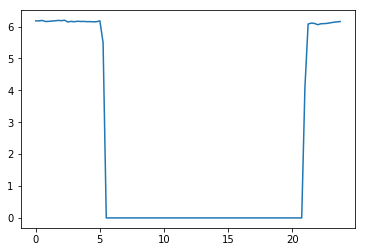

In [177]:
plt.plot(0.25*np.arange(0, 96), power[:, 0])

In [126]:
# saved_broken = chosen_sessions

In [192]:
num_runs = 100
county = 'San Francisco'
baseline_profiles = np.zeros((96, num_runs))
controlled_profiles = np.zeros((96, num_runs))
saved_indices = np.zeros((200, num_runs))
for i in range(num_runs):
    print('On run: ', i)
    
    df, df_intervals, chosen_sessions = new_df_and_sessions(county, 200)
    saved_indices[:, i] = chosen_sessions
    power, arrival_inds, departure_inds, energies = uncontrolled_load(200, chosen_sessions, df, df_intervals, 6.6)
    schedule, power = controlled_load(200, 6.6, arrival_inds, departure_inds, power, energies, energy_prices, 
                    rate_demand_peak, rate_demand_partpeak, rate_demand_overall, peak_inds, partpeak_inds)
    
    baseline_profiles[:, i] = np.sum(power, axis=1)
    controlled_profiles[:, i] = np.sum(schedule, axis=1)

On run:  0


/Users/spowell2/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Energy violation for  2  of the sessions.
The objective result:  22205.690234207355
On run:  1
Energy violation for  0  of the sessions.
The objective result:  15924.257474025146
On run:  2
Energy violation for  0  of the sessions.
The objective result:  13999.753611401444
On run:  3
Energy violation for  2  of the sessions.
The objective result:  24076.613622235967
On run:  4
Energy violation for  0  of the sessions.
The objective result:  16743.48025449423
On run:  5
Energy violation for  0  of the sessions.
The objective result:  16252.415791946696
On run:  6
Energy violation for  2  of the sessions.
The objective result:  22614.918458786753
On run:  7
Energy violation for  0  of the sessions.
The objective result:  15699.783416068687
On run:  8
Energy violation for  0  of the sessions.
The objective result:  19378.702507783775
On run:  9
Energy violation for  0  of the sessions.
The objective result:  22505.52322273905
On run:  10
Energy violation for  0  of the sessions.
The objec

Energy violation for  1  of the sessions.
The objective result:  19875.010337747837
On run:  87
Energy violation for  0  of the sessions.
The objective result:  15309.281998679126
On run:  88
Energy violation for  0  of the sessions.
The objective result:  17404.418963026717
On run:  89
Energy violation for  0  of the sessions.
The objective result:  22367.296425040928
On run:  90
Energy violation for  0  of the sessions.
The objective result:  22142.588130098135
On run:  91
Energy violation for  0  of the sessions.
The objective result:  14801.071708606218
On run:  92
Energy violation for  1  of the sessions.
The objective result:  21582.56888081551
On run:  93
Energy violation for  0  of the sessions.
The objective result:  18098.76073848948
On run:  94
Energy violation for  0  of the sessions.
The objective result:  15477.759344569673
On run:  95
Energy violation for  0  of the sessions.
The objective result:  14893.944711662294
On run:  96
Energy violation for  0  of the sessions.


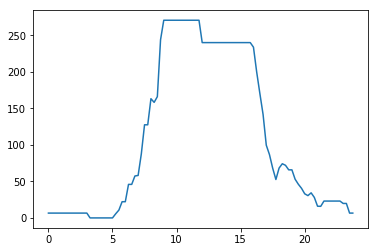

In [195]:
plt.plot(0.25*np.arange(0, 96), controlled_profiles[:, 40])

# Fitting?

In [149]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [196]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(np.transpose(baseline_profiles), np.transpose(controlled_profiles), test_size=0.2, random_state=42)

# Define and fit classifier
clf = LinearRegression()
clf.fit(X_train, y_train)

# Score on test set
clf.score(X_test, y_test)
# Pretty good R^2 value with the linear regression model

0.8540913276109795

In [197]:
# Predict on test set and inspect sample
y_predicted = clf.predict(X_test)
print('Includes ', np.shape(y_predicted)[0], 'samples.')

Includes  20 samples.


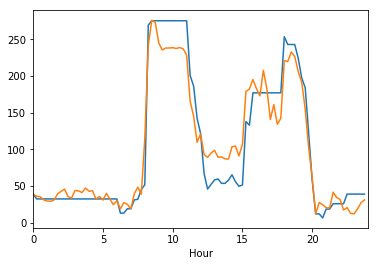

In [198]:
which_test_sample = 2  # less than num test samples
plt.figure()
plt.plot(0.25*np.arange(0, 96), y_test[which_test_sample, :])
plt.plot(0.25*np.arange(0, 96), y_predicted[which_test_sample, :])
plt.xlabel('Hour')
plt.xlim([0, 24])
plt.show()

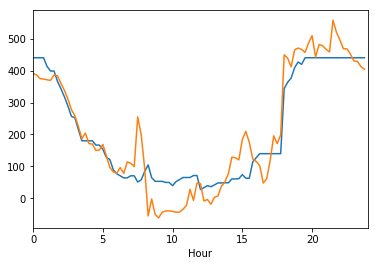

In [199]:
which_test_sample = 10  # less than num test samples
plt.figure()
plt.plot(0.25*np.arange(0, 96), y_test[which_test_sample, :])
plt.plot(0.25*np.arange(0, 96), y_predicted[which_test_sample, :])
plt.xlabel('Hour')
plt.xlim([0, 24])
plt.show()

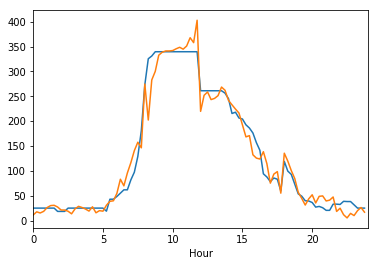

In [205]:
which_test_sample = 14  # less than num test samples
plt.figure()
plt.plot(0.25*np.arange(0, 96), y_test[which_test_sample, :])
plt.plot(0.25*np.arange(0, 96), y_predicted[which_test_sample, :])
plt.xlabel('Hour')
plt.xlim([0, 24])
plt.show()